In [1]:
# Packages for neural networks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot
import pandas 
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

importing Jupyter notebook from histplot.ipynb


In [2]:
# "converting" data, this is from a tutorial here: 
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# Upload data
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'

In [3]:
# Get Data for the completed years of 2018, 2019, and 2020
Whole18 = histplot.getData(18, direct, ASC, 1, 365, np.arange(3, 7), float)
Whole19 = histplot.getData(19, direct, ASC, 1, 365, np.arange(3, 7), float)
Whole20 = histplot.getData(20, direct, ASC, 1, 366, np.arange(3, 7), float)

In [4]:
# Have the Data then convert them into hourly data. 
def hourly(weather):
    minute = 0
    Hourly = np.zeros((8760, 4))
    hour = 0
    endminute = 60
    while (minute < len(weather[:, 3]) and hour < 8760):
        temp = np.nanmean(weather[np.arange(minute, endminute), 0])
        relhum = np.nanmean(weather[np.arange(minute, endminute), 1])
        air_p = np.nanmean(weather[np.arange(minute, endminute), 2])
        precip = np.nanmean(weather[np.arange(minute, endminute), 3])
        if (minute+60 < len(weather[:, 3])):
            minute += 60
        if (minute+60 < len(weather[:, 3])):
            endminute += 60
        else:
            endminute = len(weather[:, 3])-1
        Hourly[hour, 0] = temp
        Hourly[hour, 1] = relhum
        Hourly[hour, 2] = air_p
        Hourly[hour, 3] = 60*precip
        hour += 1
    
    return Hourly

In [5]:
hour18 = hourly(Whole18)
hour19 = hourly(Whole19)
hour20 = hourly(Whole20)

In [6]:
hourall = np.concatenate([hour18, hour19, hour20], axis = 0)
print(hourall.shape)
print(np.sum(hourall[:, 3]))

(26280, 4)
3127.8486016949155


In [7]:
new_hour = pandas.DataFrame(hourall)

In [8]:
new_hour = new_hour.rename({0: "Temperature ($^\circ C$)", 1 : "Relative Humidity (%)", 2: "Atmospheric Pressure (bar)", 3: "Precipitation (mm)"}, axis = 'columns')
new_hour

,Temperature ($^\circ C$),Relative Humidity (%),Atmospheric Pressure (bar),Precipitation (mm)
0,-10.955000,45.361667,1.017778,0.0
1,-11.401667,46.405000,1.017877,0.0
2,-11.616667,47.426667,1.018020,0.0
3,-11.930000,48.390000,1.018145,0.0
4,-12.368333,49.235000,1.018128,0.0
...,...,...,...,...
26275,5.088333,42.065000,1.016072,0.0
26276,5.028333,43.433333,1.015270,0.0
26277,4.566667,47.421667,1.014422,0.0
26278,4.046667,50.323333,1.013760,0.0


In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
values = new_hour.values
print(values)

[[-10.955       45.36166667   1.01777833   0.        ]
 [-11.40166667  46.405        1.01787667   0.        ]
 [-11.61666667  47.42666667   1.01802      0.        ]
 ...
 [  4.56666667  47.42166667   1.01442167   0.        ]
 [  4.04666667  50.32333333   1.01376      0.        ]
 [  3.58        54.32         1.01281833   0.        ]]


In [34]:
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float64')
print(values)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2]], axis=1, inplace=True)
print(reframed.head())

[[-10.955       45.36166667   1.01777833   0.        ]
 [-11.40166667  46.405        1.01787667   0.        ]
 [-11.61666667  47.42666667   1.01802      0.        ]
 ...
 [  4.56666667  47.42166667   1.01442167   0.        ]
 [  4.04666667  50.32333333   1.01376      0.        ]
 [  3.58        54.32         1.01281833   0.        ]]
   var4(t-1)   var1(t)   var2(t)   var3(t)  var4(t)
1        0.0  0.088051  0.414862  0.745857      0.0
2        0.0  0.083909  0.427592  0.748023      0.0
3        0.0  0.077872  0.439596  0.749912      0.0
4        0.0  0.069426  0.450126  0.749660      0.0
5        0.0  0.058283  0.475213  0.751045      0.0


In [36]:
# split into train and test sets
values = reframed.values
print(values)
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[0.         0.08805112 0.41486158 0.74585663 0.        ]
 [0.         0.08390867 0.42759237 0.74802277 0.        ]
 [0.         0.07787162 0.43959627 0.74991184 0.        ]
 ...
 [0.         0.39571626 0.42753006 0.69364264 0.        ]
 [0.         0.38569731 0.46368715 0.68364314 0.        ]
 [0.         0.37670595 0.51348882 0.66941212 0.        ]]
(8760, 1, 4) (8760,) (17519, 1, 4) (17519,)


Epoch 1/50
122/122 - 1s - loss: 0.0075 - val_loss: 0.0039
Epoch 2/50
122/122 - 0s - loss: 0.0045 - val_loss: 0.0036
Epoch 3/50
122/122 - 0s - loss: 0.0046 - val_loss: 0.0037
Epoch 4/50
122/122 - 0s - loss: 0.0043 - val_loss: 0.0051
Epoch 5/50
122/122 - 0s - loss: 0.0043 - val_loss: 0.0041
Epoch 6/50
122/122 - 1s - loss: 0.0044 - val_loss: 0.0047
Epoch 7/50
122/122 - 1s - loss: 0.0044 - val_loss: 0.0039
Epoch 8/50
122/122 - 1s - loss: 0.0045 - val_loss: 0.0036
Epoch 9/50
122/122 - 1s - loss: 0.0043 - val_loss: 0.0035
Epoch 10/50
122/122 - 1s - loss: 0.0041 - val_loss: 0.0041
Epoch 11/50
122/122 - 0s - loss: 0.0042 - val_loss: 0.0037
Epoch 12/50
122/122 - 0s - loss: 0.0042 - val_loss: 0.0035
Epoch 13/50
122/122 - 0s - loss: 0.0044 - val_loss: 0.0052
Epoch 14/50
122/122 - 0s - loss: 0.0042 - val_loss: 0.0038
Epoch 15/50
122/122 - 0s - loss: 0.0042 - val_loss: 0.0035
Epoch 16/50
122/122 - 0s - loss: 0.0043 - val_loss: 0.0037
Epoch 17/50
122/122 - 0s - loss: 0.0043 - val_loss: 0.0033
Epoch 

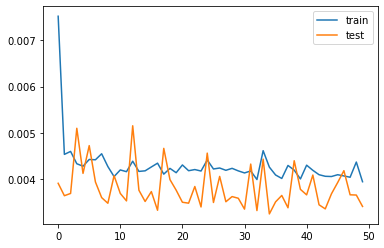

In [37]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [38]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, :3], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
print(inv_yhat)
inv_yhat = inv_yhat[:,3]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, :3], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,3]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


[[-1.57960086e+01  4.79764686e+01  1.03166181e+00  2.89274117e-02]
 [-1.55724439e+01  4.83346775e+01  1.03203834e+00  8.32220748e-02]
 [-8.45030968e+00  4.85511490e+01  1.03225135e+00  1.71800615e+00]
 ...
 [-1.59716667e+01  4.48685559e+01  9.96812998e-01  2.24861037e-03]
 [-1.59716667e+01  4.40645188e+01  9.99205512e-01  6.94381865e-04]
 [-1.59716667e+01  4.33429470e+01  1.00250089e+00 -1.49717227e-03]]
Test RMSE: 0.792


300.1207656541256

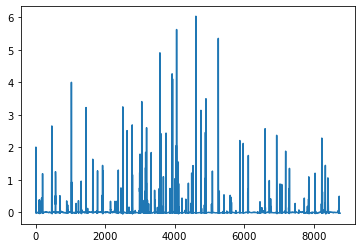

In [42]:
plt.plot(inv_yhat[:8760])
np.sum(inv_yhat[:8760])

1028.6340677966102

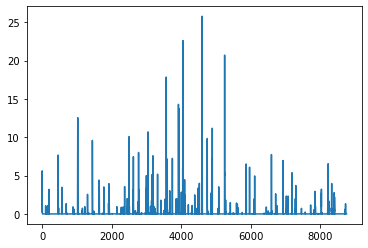

In [43]:
plt.plot(inv_y[:8760])
np.sum(inv_y[:8760])

In [44]:
Whole_all = np.concatenate([Whole18, Whole19, Whole20], axis = 0)
print(Whole_all.shape)
Whole_all = Whole_all[~np.isnan(Whole_all).any(axis = 1), :]
print(Whole_all.shape)

(1578191, 4)
(1578098, 4)


In [45]:
new_minute = pandas.DataFrame(Whole_all)

In [46]:
new_minute = new_minute.rename({0: "Temperature ($^\circ C$)", 1 : "Relative Humidity (%)", 2: "Atmospheric Pressure (bar)", 3: "Precipitation (mm)"}, axis = 'columns')
new_minute

,Temperature ($^\circ C$),Relative Humidity (%),Atmospheric Pressure (bar),Precipitation (mm)
0,-11.1,45.5,1.0177,0.0
1,-11.1,45.3,1.0177,0.0
2,-11.1,45.1,1.0177,0.0
3,-11.1,46.2,1.0177,0.0
4,-11.1,45.4,1.0177,0.0
...,...,...,...,...
1578093,4.9,61.2,1.0173,0.0
1578094,4.9,60.8,1.0174,0.0
1578095,4.9,60.7,1.0174,0.0
1578096,4.9,61.3,1.0174,0.0


In [47]:
values = new_minute.values
print(values)

[[-11.1     45.5      1.0177   0.    ]
 [-11.1     45.3      1.0177   0.    ]
 [-11.1     45.1      1.0177   0.    ]
 ...
 [  4.9     60.7      1.0174   0.    ]
 [  4.9     61.3      1.0174   0.    ]
 [  4.9     60.1      1.0175   0.    ]]


In [48]:
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])

# normalize features
scaler =  MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2]], axis=1, inplace=True)
print(reframed.head())

   var4(t-1)   var1(t)   var2(t)   var3(t)  var4(t)
1        0.0  0.096591  0.407635  0.746291      0.0
2        0.0  0.096591  0.405172  0.746291      0.0
3        0.0  0.096591  0.418719  0.746291      0.0
4        0.0  0.096591  0.408867  0.746291      0.0
5        0.0  0.096591  0.413793  0.746291      0.0


In [49]:
# split into train and test sets
values = reframed.values
print(values)
n_train_hours = 365 * 24 * 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[0.         0.09659091 0.40763547 0.7462908  0.        ]
 [0.         0.09659091 0.40517241 0.7462908  0.        ]
 [0.         0.09659091 0.41871921 0.7462908  0.        ]
 ...
 [0.         0.39962121 0.59729064 0.74183976 0.        ]
 [0.         0.39962121 0.6046798  0.74183976 0.        ]
 [0.         0.39962121 0.58990148 0.74332344 0.        ]]
(525600, 1, 4) (525600,) (1052497, 1, 4) (1052497,)


Epoch 1/50
7300/7300 - 26s - loss: 0.0029 - val_loss: 0.0086
Epoch 2/50
7300/7300 - 26s - loss: 0.0018 - val_loss: 0.0040
Epoch 3/50
7300/7300 - 25s - loss: 0.0015 - val_loss: 0.0034
Epoch 4/50
7300/7300 - 24s - loss: 0.0015 - val_loss: 0.0039
Epoch 5/50
7300/7300 - 23s - loss: 0.0013 - val_loss: 0.0034
Epoch 6/50
7300/7300 - 20s - loss: 0.0013 - val_loss: 0.0025
Epoch 7/50
7300/7300 - 19s - loss: 0.0011 - val_loss: 0.0024
Epoch 8/50
7300/7300 - 25s - loss: 0.0011 - val_loss: 0.0023
Epoch 9/50
7300/7300 - 24s - loss: 0.0010 - val_loss: 0.0022
Epoch 10/50
7300/7300 - 24s - loss: 9.5019e-04 - val_loss: 0.0026
Epoch 11/50
7300/7300 - 24s - loss: 0.0010 - val_loss: 0.0024
Epoch 12/50
7300/7300 - 24s - loss: 0.0010 - val_loss: 0.0022
Epoch 13/50
7300/7300 - 26s - loss: 9.8671e-04 - val_loss: 0.0021
Epoch 14/50
7300/7300 - 21s - loss: 0.0010 - val_loss: 0.0021
Epoch 15/50
7300/7300 - 24s - loss: 0.0011 - val_loss: 0.0017
Epoch 16/50
7300/7300 - 23s - loss: 0.0010 - val_loss: 0.0016
Epoch 17/

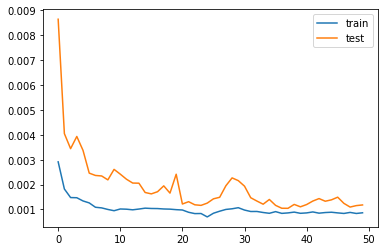

In [50]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [51]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X)
# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, :3], yhat), axis=1)
print(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
print(inv_yhat)
inv_yhat = inv_yhat[:,3]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate(( test_X[:, :3], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,3]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


[[0.         0.42424242 0.94827586 0.61127596]
 [0.         0.42424242 0.94950739 0.60979228]
 [0.         0.42613636 0.95073892 0.60979228]
 ...
 [0.         0.39962121 0.59729064 0.74183976]
 [0.         0.39962121 0.6046798  0.74183976]
 [0.         0.39962121 0.58990148 0.74332344]]
[[0.         0.42424242 0.94827586 0.00113265]
 [0.         0.42424242 0.94950739 0.00111902]
 [0.         0.42613636 0.95073892 0.00110739]
 ...
 [0.         0.39962121 0.59729064 0.00173047]
 [0.         0.39962121 0.6046798  0.00174432]
 [0.         0.39962121 0.58990148 0.00172552]]
[[-1.62000000e+01  4.66484848e+01  1.03131379e+00  3.40929107e-03]
 [-1.62000000e+01  4.66484848e+01  1.03139680e+00  3.36824999e-03]
 [-1.62000000e+01  4.68022727e+01  1.03147980e+00  3.33323596e-03]
 ...
 [-1.62000000e+01  4.46492424e+01  1.00765739e+00  5.20872132e-03]
 [-1.62000000e+01  4.46492424e+01  1.00815542e+00  5.25040540e-03]
 [-1.62000000e+01  4.46492424e+01  1.00715936e+00  5.19381067e-03]]
Test RMSE: 0.012

2153.664718038843

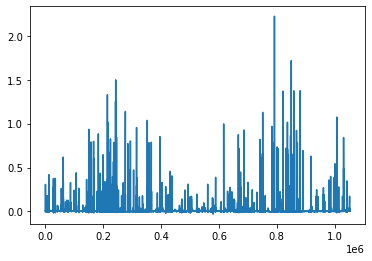

In [55]:
plt.plot(inv_yhat)
np.sum(inv_yhat)

1985.6600000000003

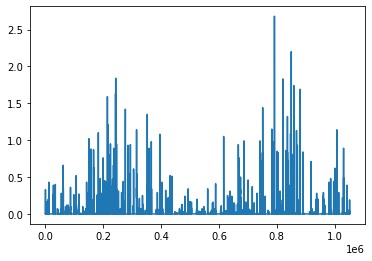

In [56]:
plt.plot(inv_y)
np.sum(inv_y)